In [1]:
%load_ext autoreload
%autoreload 2

import functools
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import sys
sys.path.append('..')
import time
import warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter(action='ignore')

import diffrax
import flax
from flax.training import checkpoints
import IPython.display as ipd
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax

from configs import dpi_config as dpi_config_provider
from configs import score_config as score_config_provider

import forward_models
import probability_bound
import probability_flow
from posterior_sampling import model_utils as dpi_mutils
from score_flow import utils
from score_flow.models import utils as score_mutils
from score_flow.models import ddpm, ncsnpp, ncsnv2

2024-02-05 13:29:58.167206: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Welcome to eht-imaging! v 1.2.5 



# Posterior Sampling with Score-based Priors: Image Denoising

This notebook demonstrates how to use score-based priors for image denoising. We will use a variational-inference approach known as Deep Probabilistic Imaging (DPI) to sample from the posterior.

In [2]:
"""
We define settings for this experiment through a `ConfigDict` for DPI.
A `ConfigDict` for the score model is used to help load the score-based prior.
"""

# Get DPI config.
config = dpi_config_provider.get_config()

config.data.image_size = 32
config.data.num_channels = 3

config.likelihood.likelihood = 'Denoising'
config.likelihood.noise_scale = 0.2

config.model.n_flow = 32
config.model.seqfrac = 4

config.training.batch_size = 32
config.optim.learning_rate = 2e-4
config.optim.grad_clip = 1.
config.optim.prior = 'ode'  # Change to 'dsm' to use probability lower bound.

# Get score-model config.
score_config = score_config_provider.get_config()
score_config.model.beta_max = 20.
score_config.model.nf = 64

image_shape = (config.data.image_size, config.data.image_size, config.data.num_channels)
image_dim = np.prod(image_shape)

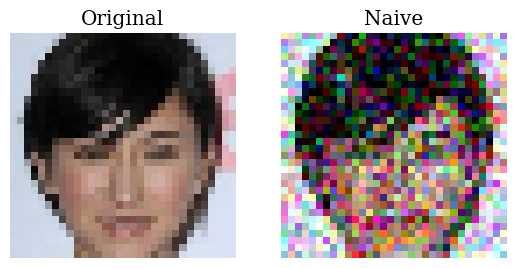

In [3]:
"""
We wrap the measurement simulation and measurement-likelihood functions inside
the `forward_models.Denoising` object.
"""
likelihood = forward_models.Denoising(
  scale=config.likelihood.noise_scale,
  image_shape=image_shape)

# Load true image.
true_image = np.load('test_data/celeba_test_image.npy')
# Simulate noisy measurements.
meas_rng = jax.random.PRNGKey(0)
y = likelihood.get_measurement(meas_rng, true_image[None, ...])
naive_image = np.clip(y.reshape(image_shape), 0., 1.)

plt.subplot(121)
plt.imshow(true_image); plt.axis('off')
plt.title('Original')
plt.subplot(122)
plt.imshow(naive_image); plt.axis('off')
plt.title('Naive');

## Score-based prior

A trained score-based diffusion model with parameters $\theta$ generates images from its *score-based prior*, which we denote as $p_\theta$. Given any image $\mathbf{x}$, we can compute $\log p_\theta(\mathbf{x})$ with the *probability flow ODE*:
\begin{align*}
\frac{\mathrm{d}\mathbf{x}_t}{\mathrm{d}t}&=\mathbf{f}(\mathbf{x}_t,t)-\frac{1}{2}g(t)^2\mathbf{s}_\theta(\mathbf{x}_t,t)\\
&=:\tilde{\mathbf{f}}_\theta(\mathbf{x}_t,t),
\end{align*}
where $\mathbf{s}_\theta$ is the learned score model, and $\mathbf{f}(\mathbf{x}_t,t)$ and $g(t)$ are the drift and diffusion coefficients, respectively, of the diffusion SDE.

We compute the log-probability through an initial-value problem:
\begin{align*}
\log p_\theta(\mathbf{x})&:=\log p_0(\mathbf{x}) \\
&= \log p_T(\mathbf{x}_T)+\int_0^T\nabla\cdot\tilde{\mathbf{f}}_\theta(\mathbf{x}_t,t)\mathrm{d}t,\quad \mathbf{x}_0=\mathbf{x},
\end{align*}
where $p_t$ is the time-dependent marginal probability distribution of $\mathbf{x}_t$ under the diffusion SDE.

In practice we solve this ODE using [Diffrax](https://docs.kidger.site/diffrax/). Here we use the Dopri5 solver with adaptive step-sizing.

In [4]:
"""
This score-based prior was trained on 32x32 CelebA images.
"""
score_model_ckpt_path = '../score_checkpoints/CELEBA_32/checkpoints/checkpoint_1000000'

# Get SDE.
sde, t0 = utils.get_sde(score_config)

# Initialize score model.
score_model, _, _ = score_mutils.init_model(jax.random.PRNGKey(0), score_config)
score_state = score_mutils.State(
    step=0,
    model_state=None,
    opt_state=None,
    ema_rate=score_config.model.ema_rate,
    params=None,
    params_ema=None,
    rng=jax.random.PRNGKey(0))

# Load score-model checkpoint.
score_state = checkpoints.restore_checkpoint(score_model_ckpt_path, score_state)

# Get score function based on trained score model.
score_fn = score_mutils.get_score_fn(
  sde,
  score_model,
  score_state.params_ema,
  score_state.model_state,
  train=False,
  continuous=True)

# Wrap probability flow ODE computations inside `probability_flow.ProbabilityFlow`.
# We will use this to sample from the prior and, if `config.optim.prior == 'ode'`,
# to compute log-probabilities.
solver = diffrax.Dopri5()
stepsize_controller = diffrax.PIDController(rtol=1e-3, atol=1e-5)
# NOTE: it might be possible to use `diffrax.RecursiveCheckpointAdjoint`
# instead of `BacksolveAdjoint`.
adjoint = diffrax.BacksolveAdjoint(
  solver=diffrax.Dopri5(),
  stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-5, norm=diffrax.adjoint_rms_seminorm))
prob_flow = probability_flow.ProbabilityFlow(
  sde=sde,
  score_fn=score_fn,
  solver=solver,
  stepsize_controller=stepsize_controller,
  adjoint=adjoint,
  n_trace_estimates=16)

# Get function for computing ELBO, which is used if `config.optim.prior == 'dsm'`.
bound_fn = probability_bound.get_likelihood_bound_fn(
    sde, score_fn, image_dim,
    dsm=True, eps=t0, N=config.optim.dsm_nt, importance_weighting=True,
    eps_offset=True)

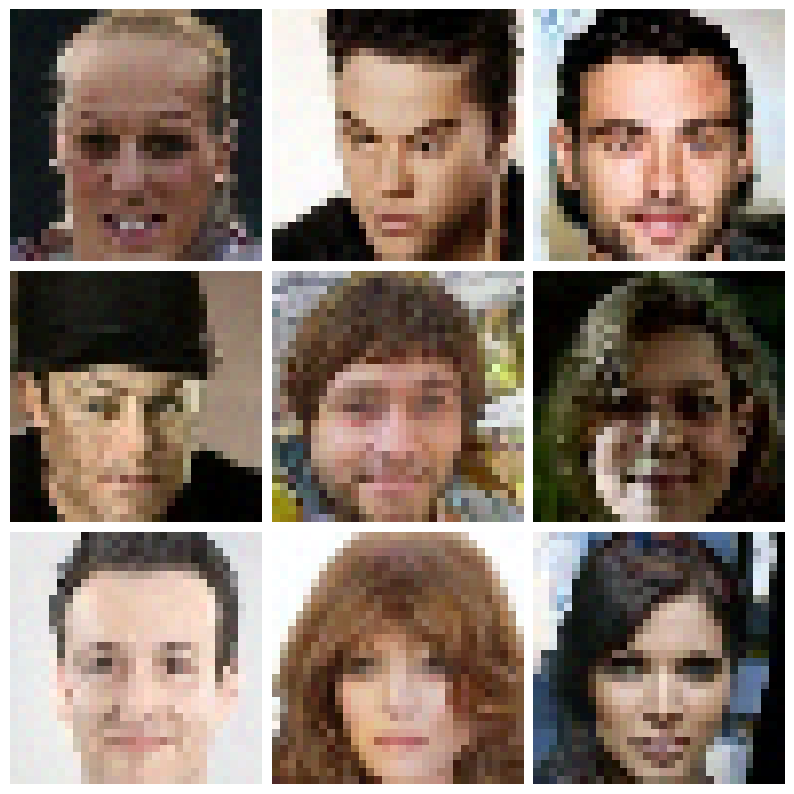

In [5]:
"""
Check ODE samples.
"""
z = jax.random.normal(jax.random.PRNGKey(0), (9, *image_shape))
samples, _ = prob_flow.ode(z, sde.T, t0, dt0=None)
utils.plot_image_grid(samples[:9]);

## DPI optimization

In [6]:
"""
Here we define the objective functions and update step for the RealNVP.
"""

sampling_shape = (config.training.batch_size // jax.local_device_count(), *image_shape)

# Define data loss function (aka negative log measurement likelihood).
def data_loss_fn(x):
  log_likelihood = likelihood.unnormalized_log_likelihood(x, y)
  return -jnp.mean(log_likelihood)


# Define prior loss function (aka negative log prior).
if config.optim.prior == 'ode':
  logp_fn = functools.partial(prob_flow.logp_fn, t0=t0, t1=sde.T, dt0=None)
  def prior_loss_fn(rng, x):
    log_prior = logp_fn(rng, x)
    return -jnp.mean(log_prior)
elif config.optim.prior == 'dsm':
  def prior_loss_fn(rng, x):
    bound = bound_fn(rng, x)
    return -jnp.mean(bound)


def get_loss_fn(model):
  def loss_fn(rng, params, model_state):
    # Get samples.
    sample_fn = dpi_mutils.get_sampling_fn(model, params, model_state, train=True)
    rng, step_rng = jax.random.split(rng)
    (samples, reverse_logdet), new_model_state = sample_fn(step_rng, sampling_shape)

    # Data loss.
    data_loss = data_loss_fn(samples)

    # Prior loss.
    rng, step_rng = jax.random.split(rng)
    prior_loss = prior_loss_fn(step_rng, samples)

    # Entropy loss.
    entropy_loss = -jnp.mean(reverse_logdet)

    # Total loss.
    loss = data_loss + prior_loss + entropy_loss
    
    return loss, (new_model_state, samples, data_loss, prior_loss, entropy_loss)

  return loss_fn


def get_step_fn(model, optimizer):
  loss_fn = get_loss_fn(model)
  loss_and_grad_fn = jax.value_and_grad(loss_fn, argnums=1, has_aux=True)
  
  def step_fn(rng, state):
    rng, step_rng = jax.random.split(rng)
    (loss, (new_model_state, samples, data_loss, prior_loss, entropy_loss)), grad = loss_and_grad_fn(
      step_rng, state.params, state.model_state)
    grad = jax.lax.pmean(grad, axis_name='batch')
    loss = jax.lax.pmean(loss, axis_name='batch')
    data_loss = jax.lax.pmean(data_loss, axis_name='batch')
    prior_loss = jax.lax.pmean(prior_loss, axis_name='batch')
    entropy_loss = jax.lax.pmean(entropy_loss, axis_name='batch')

    # Apply updates.
    updates, new_opt_state = optimizer.update(grad, state.opt_state, state.params)
    new_params = optax.apply_updates(state.params, updates)

    step = state.step + 1
    new_state = state.replace(
        step=step,
        opt_state=new_opt_state,
        params=new_params,
        model_state=new_model_state,
        rng=rng)

    return new_state, (loss, data_loss, prior_loss, entropy_loss), samples

  return step_fn

In [7]:
"""
We define a function for showing DPI optimization progress.
"""
def plot_dpi_progress(step, samples, losses_total, losses_data, losses_prior, losses_entropy):
  mean = np.mean(samples, axis=0)
  std = np.std(samples, axis=0)
  std = np.mean(std, axis=-1)  # average std. dev. across channels

  fig, axs = plt.subplots(3, 3, figsize=(20, 18))
  fig.suptitle(f'step {step}', fontsize=20)

  ax = axs[0, 0]
  ax.plot(losses_data); ax.set_title('data loss', fontsize=18)

  ax = axs[0, 1]
  ax.plot(losses_prior); ax.set_title('prior loss', fontsize=18)

  ax = axs[0, 2]
  ax.plot(losses_entropy); ax.set_title('entropy loss', fontsize=18)

  ax = axs[1, 0]
  ax.plot(losses_total); ax.set_title('total loss', fontsize=18)

  ax = axs[1, 1]
  ax.set_title('mean', fontsize=18)
  p = ax.imshow(np.clip(mean, 0., 1.))
  ax.axis('off')
  fig.colorbar(p, ax=ax)

  ax = axs[1, 2]
  ax.set_title(f'std dev (n = {len(samples)})', fontsize=18)
  p = ax.imshow(std); ax.axis('off');
  fig.colorbar(p, ax=ax)

  for i in range(3):
    ax = axs[2, i]
    ax.imshow(np.clip(samples[i], 0., 1.))
    ax.axis('off')
    ax.set_title('sample', fontsize=18)

  return fig

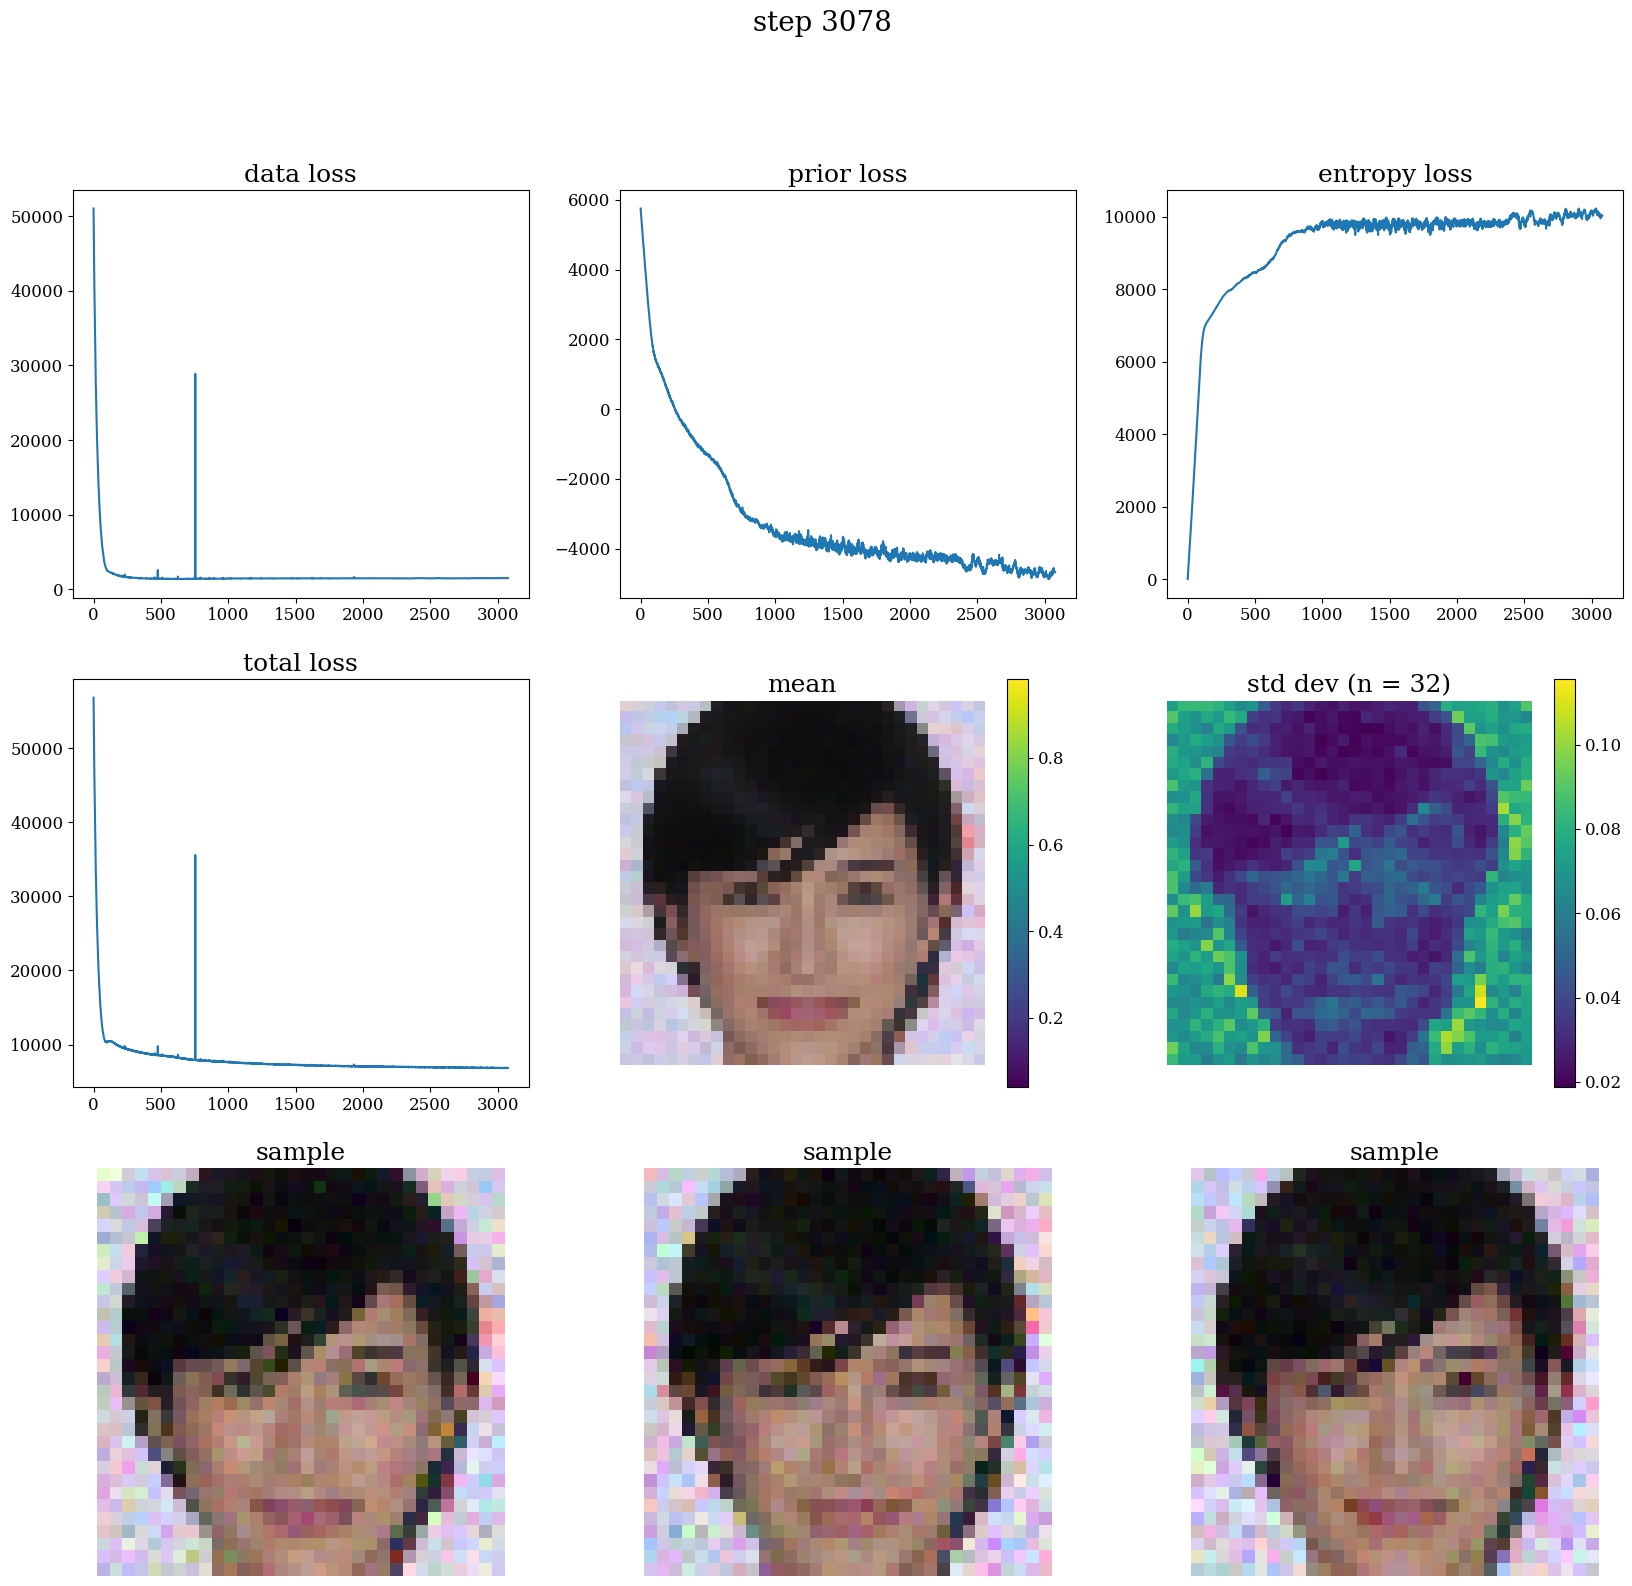

time/step: 50.87 sec


In [ ]:
"""
We iteratively sample from the RealNVP, estimate its KL divergence to the target posterior,
and update the RealNVP parameters with gradients to minimize the KL divergence.
"""
initialize = True
rejit_step_fn = True  # Set to `False` to save time re-jitting step function.

load_checkpoint = False
save_ckpts = False
ckpt_freq = 100  # Save DPI checkpoint every `ckpt_freq` steps.
ckpt_dir = 'checkpoints/denoising'
vis_freq = 1  # Visualize DPI progress every `vis_freq` steps.

if save_ckpts:
  os.makedirs(ckpt_dir, exist_ok=True)

if initialize:
  losses_total, losses_data, losses_prior, losses_entropy = [], [], [], []

  # Initialize model.
  model, model_state, params = dpi_mutils.get_model_and_init_params(
      config,
      train=True)
  
  # Initialize optimizer.
  optimizer = optax.chain(
    optax.clip_by_global_norm(config.optim.grad_clip),
    optax.adam(
      learning_rate=config.optim.learning_rate,
      b1=config.optim.adam_beta1, b2=config.optim.adam_beta2,
      eps=config.optim.adam_eps))
  opt_state = optimizer.init(params)
  
  # Initialize training state.
  state = dpi_mutils.State(
    step=0,
    opt_state=opt_state,
    params=params,
    model_state=model_state,
    data_weight=1.,
    prior_weight=1.,
    entropy_weight=1.,
    rng=jax.random.PRNGKey(config.seed + 1))
  
  if load_checkpoint:
    state = flax.training.checkpoints.restore_checkpoint(ckpt_dir, state)
  print(f'Starting from step {state.step}', flush=True)

  # Replicate training state.
  pstate = flax.jax_utils.replicate(state)

if rejit_step_fn:
  step_fn = get_step_fn(model, optimizer)
  p_train_step = jax.pmap(jax.jit(step_fn), axis_name='batch')


n_steps = 10000
init_step = flax.jax_utils.unreplicate(pstate.step)
rng = state.rng

for step in range(init_step, n_steps):
  start_time = time.perf_counter()

  # Train step.
  rng, step_rngs = utils.psplit(rng)
  pstate, (ploss, ploss_data, ploss_prior, ploss_entropy), psamples = p_train_step(
      step_rngs, pstate)

  # Unreplicate losses, samples.
  loss = flax.jax_utils.unreplicate(ploss).item()
  loss_data = flax.jax_utils.unreplicate(ploss_data).item()
  loss_prior = flax.jax_utils.unreplicate(ploss_prior).item()
  loss_entropy = flax.jax_utils.unreplicate(ploss_entropy).item()
  samples = psamples.reshape(config.training.batch_size, *image_shape)

  # Update losses.
  losses_total.append(loss)
  losses_data.append(loss_data)
  losses_prior.append(loss_prior)
  losses_entropy.append(loss_entropy)

  step_time = time.perf_counter() - start_time

  if save_ckpts and ((step + 1) % ckpt_freq == 0):
    # Save model checkpoint.
    flax.training.checkpoints.save_checkpoint(
      ckpt_dir,
      flax.jax_utils.unreplicate(pstate),
      step=step + 1,
      keep=np.inf)

  if (step + 1) % vis_freq == 0 or step == 0:
    ipd.clear_output(wait=True)
    fig = plot_dpi_progress(
        step + 1, samples, losses_total, losses_data, losses_prior, losses_entropy);
    plt.show()
    print(f'time/step: {step_time:.2f} sec', flush=True)